In [629]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor 
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, accuracy_score, r2_score
from sklearn.preprocessing import PolynomialFeatures
import scipy as scp
import scipy.stats as ss
from scipy.optimize import minimize
from scipy import sparse
from scipy.sparse.linalg import spsolve
from mpl_toolkits import mplot3d
from matplotlib import cm
import scipy.special as scsp
from scipy.integrate import quad
from scipy.interpolate import RegularGridInterpolator
from MarketUtils import *
import pyfolio as pf
from datetime import datetime
from ouparams import ouparams
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kendalltau, pearsonr, spearmanr
from scipy.optimize import minimize
from scipy.integrate import quad
import sys
from collections import deque
from IStrategy import IStrategy
import pandas as pd
import pyvinecopulib as pv
from ouparams import ouparams
from copulas.multivariate import  VineCopula
import math

In [636]:
def OUFit(spread):
    spread = (spread - spread.mean())/spread.std()
    mu, sigma, theta = ouparams.find(spread)
    if not np.log(2)/theta : 
       return sigma,mu,100
    return sigma,mu,np.log(2)/theta

def dummy_strategy_l(x_train, y_train, x_test, y_test, isconver = True):
    return np.zeros(len(y_test)), np.ones(len(y_test))

def dummy_strategy_s(x_train, y_train, x_test, y_test, isconver = True):
    return np.zeros(len(y_test)), -np.ones(len(y_test))

In [750]:
def misprice_index(u,v,copula,theta):
        '''Calculate mispricing index for every day in the trading period by using estimated copula
        Mispricing indices are the conditional probability P(U < u | V = v) and P(V < v | U = u)'''

        if copula == 'clayton':
            MI_u_v = v ** (-theta - 1) * (u ** (-theta) + v ** (-theta) - 1) ** (
                        -1 / theta - 1)  # P(U<u|V=v)
            MI_v_u = u ** (-theta - 1) * (u ** (-theta) + v ** (-theta) - 1) ** (
                        -1 / theta - 1)  # P(V<v|U=u)

        elif copula == 'frank':
            A = (np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta * v) - 1)
            B = (np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta * u) - 1)
            C = (np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta) - 1)
            MI_u_v = B / C
            MI_v_u = A / C

        elif copula == 'gumbel':
            A = (-np.log(u)) ** theta + (-np.log(v)) ** theta
            C_uv = np.exp(-A ** (1 / theta))  # C_uv is gumbel copula function C(u,v)
            MI_u_v = C_uv * (A ** ((1 - theta) / theta)) * (-np.log(v)) ** (theta - 1) * (1.0 / v)
            MI_v_u = C_uv * (A ** ((1 - theta) / theta)) * (-np.log(u)) ** (theta - 1) * (1.0 / u)

        return MI_u_v , MI_v_u 

def _lpdf_copula(family, theta, u, v):
        '''Estimate the log probability density function of three kinds of Archimedean copulas
        '''

        if family == 'clayton':
            pdf = (theta + 1) * ((u ** (-theta) + v ** (-theta) - 1) ** (-2 - 1 / theta)) * (
                        u ** (-theta - 1) * v ** (-theta - 1))

        elif family == 'frank':
            num = -theta * (np.exp(-theta) - 1) * (np.exp(-theta * (u + v)))
            denom = ((np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta) - 1)) ** 2
            pdf = num / denom

        elif family == 'gumbel':
            A = (-np.log(u)) ** theta + (-np.log(v)) ** theta
            c = np.exp(-A ** (1 / theta))
            pdf = c * (u * v) ** (-1) * (A ** (-2 + 2 / theta)) * ((np.log(u) * np.log(v)) ** (theta - 1)) * (1 + (theta - 1) * A ** (-1 / theta))

        return np.log(pdf)

def _parameter(family, tau):
        ''' Estimate the parameters for three kinds of Archimedean copulas
        according to association between Archimedean copulas and the Kendall rank correlation measure
        '''

        if family == 'clayton':
            return 2 * tau / (1 - tau)

        elif family == 'frank':
            '''
            debye = quad(integrand, sys.float_info.epsilon, theta)[0]/theta  is first order Debye function
            frank_fun is the squared difference
            Minimize the frank_fun would give the parameter theta for the frank copula 
            '''
            integrand = lambda t: t / (np.exp(t) - 1)  # generate the integrand
            frank_fun = lambda theta: ((tau - 1) / 4.0 - (
                        quad(integrand, sys.float_info.epsilon, theta)[0] / theta - 1) / theta) ** 2

            return minimize(frank_fun, 4, method='BFGS', tol=1e-5).x[0]

        elif family == 'gumbel':
            return 1 / (1 - tau)

def get_strategy_copula2(x_train, y_train, x_test, y_test, isconver = True):

    #Get standard deviation for historical spread
    scaler = StandardScaler()
    x_train = np.diff(np.log(x_train))[1:]
    y_train = np.diff(np.log(y_train))[1:]
    x_train = scaler.fit_transform(x_train.reshape(-1, 1))
    ecdfx = ECDF(x_train.flatten())
    ecdfy = ECDF(y_train.flatten())
    u, v = [ecdfx(a) for a in x_train], [ecdfy(a) for a in y_train]
    tau = kendalltau(x_train, y_train)[0]  # estimate Kendall'rank correlation
    AIC = {}  # generate a dict with key being the copula family, value = [theta, AIC]
    s = ['clayton','frank', 'gumbel']
    for i in s:
        param = _parameter(i, tau)
        lpdf = [_lpdf_copula(i, param, x, y) for (x, y) in zip(u, v)]
        lpdf = np.nan_to_num(lpdf)
        loglikelihood = sum(lpdf)
        AIC[i] = [param, -2 * loglikelihood + 2]

    copula = min(AIC.items(), key=lambda x: x[1][1])[0]
    tau = kendalltau(x_train, y_train)[0]
    theta = _parameter(copula, tau)
    #Backtesting
    x_test = np.diff(np.log(x_test))[1:]
    x_test = scaler.transform(x_test.reshape(-1, 1))
    y_test = np.diff(np.log(y_test))[1:]

    # Convert the two returns to uniform values u and v using the empirical distribution functions
    x_test = ecdfx(x_test.flatten())
    y_test = ecdfy(y_test.flatten())
    
    M_x = np.array([misprice_index(x,y,copula,theta)[0] for x,y in zip(x_test,y_test)]) - 0.5
    M_y = np.array([misprice_index(x,y,copula,theta)[1] for x,y in zip(x_test,y_test)]) - 0.5
    flagx = M_x.cumsum()
    flagy = M_y.cumsum()

    #Get Strategy with Risk Management
    strategy = np.zeros(len(y_test))
    if isconver:
        for i in range(len(y_test) - len(flagx), len(flagx)):     
            if (flagx[i] > 0.6 and flagy[i] < -0.6):
                strategy[i] = -1
                
            elif (flagy[i] > 0.6 and flagx[i] < -0.6):
                strategy[i] = 1 

    else:
        for i in range(len(y_test) - len(flagx), len(flagx)):     

            if (flagx[i] > 0.5 or flagy[i] < -0.5):
                strategy[i] = 1
                
            elif (flagy[i] > 0.5 or flagx[i] < -0.5):
                strategy[i] = -1
                         
    return flagx, strategy

def get_strategy_copula_rm2(x_train, y_train, x_test, y_test, \
                           alter_train, alter_test, isconver = False ):

    x_train = np.diff(np.log(x_train))[1:]
    y_train = np.diff(np.log(y_train))[1:]
    ecdfx = ECDF(x_train.flatten())
    ecdfy = ECDF(y_train.flatten())
    u, v = [ecdfx(a) for a in x_train], [ecdfy(a) for a in y_train]
    tau = kendalltau(x_train, y_train)[0]  # estimate Kendall'rank correlation
    AIC = {}  # generate a dict with key being the copula family, value = [theta, AIC]
    s = ['clayton','frank', 'gumbel']
    for i in s:
        param = _parameter(i, tau)
        lpdf = [_lpdf_copula(i, param, x, y) for (x, y) in zip(u, v)]
        lpdf = np.nan_to_num(lpdf)
        loglikelihood = sum(lpdf)
        AIC[i] = [param, -2 * loglikelihood + 2]

    copula = min(AIC.items(), key=lambda x: x[1][1])[0]
    tau = kendalltau(x_train, y_train)[0]
    theta = _parameter(copula, tau)
    #Backtesting
    x_test = np.diff(np.log(x_test))[1:]
    y_test = np.diff(np.log(y_test))[1:]

    # Convert the two returns to uniform values u and v using the empirical distribution functions
    x_test = ecdfx(x_test.flatten())
    y_test = ecdfy(y_test.flatten())

    x_train = ecdfx(x_train.flatten())
    y_train = ecdfy(y_train.flatten())

    M_x_train = np.array([misprice_index(x,y,copula,theta)[0] for x,y in zip(x_train,y_train)]) - 0.5
    M_y_train = np.array([misprice_index(x,y,copula,theta)[1] for x,y in zip(x_train,y_train)]) - 0.5
    flagx_train = M_x_train.cumsum()
    flagy_train = M_y_train.cumsum()
    
    M_x = np.array([misprice_index(x,y,copula,theta)[0] for x,y in zip(x_test,y_test)]) - 0.5
    M_y = np.array([misprice_index(x,y,copula,theta)[1] for x,y in zip(x_test,y_test)]) - 0.5
    flagx = M_x.cumsum()
    flagy = M_y.cumsum()

    sigma_x, mu_x, hlf_x = OUFit(flagx_train)
    sigma_y, mu_y, hlf_y = OUFit(flagy_train)
    alter_cols = ['fedfunds','vix','vol_spread','Flat','News Sentiment']

    if (hlf_x and hlf_y) and (hlf_x > 0 and hlf_y > 0) and (hlf_x < 16 and hlf_y < 16):
        isconver = True

    thresh = 0.5
    strategy = np.zeros(len(y_test))
    for i in range(len(y_test) - len(flagx), len(flagx)):
        lever = 1
        if abs(alter_test[i][4]) > 0.2 or alter_train[i][1] > 30:
           thresh = 0.8
           isconver = False

        if isconver:
            print("I am convergent")  
            if (flagx[i] > thresh or flagy[i] < -thresh) or (strategy[i-1] == -1 and (flagx[i] > 0 or flagy[i] < 0)):
                strategy[i] = -1
                
            elif (flagy[i] > thresh or flagx[i] < -thresh) or (strategy[i-1] == 1 and (flagy[i] > 0 or flagx[i] < 0)):
                strategy[i] = 1 

        else:     
            if (flagx[i] > thresh or flagy[i] < -thresh):
                strategy[i] = 1
                
            elif (flagy[i] > thresh or flagx[i] < -thresh):
                strategy[i] = -1

        strategy[i] *= lever  
                       
    return flagx, strategy

from sklearn.decomposition import PCA

def get_strategy_copula(x_train, y_train, x_test, y_test, isconver = True):
    scaler = StandardScaler()
    x_train = np.diff(np.log(x_train))[1:]
    y_train = np.diff(np.log(y_train))[1:]
    x_train = scaler.fit_transform(x_train.reshape(-1, 1))
    
    ecdfx = ECDF(x_train.flatten())
    ecdfy = ECDF(y_train.flatten())

    u_data = np.array([[x,y] for x,y in zip(ecdfx(x_train.flatten()), ecdfy(y_train.flatten()))])
    model = pv.Vinecop(data = u_data)

    x_test = np.diff(np.log(x_test))[1:]
    x_test = scaler.transform(x_test.reshape(-1, 1))
    y_test = np.diff(np.log(y_test))[1:]

    # Convert the two returns to uniform values u and v using the empirical distribution functions
    x_test = ecdfx(x_test.flatten())
    y_test = ecdfy(y_test.flatten())
    integrand1 = lambda x,y : model.pdf(np.array([[x,y]]))
    integrand2 = lambda y,x : model.pdf(np.array([[x,y]]))
    M_x = np.array([quad(integrand1,0,x,args=(y,))[0]/(quad(integrand1,0,x,args=(y,))[0] + quad(integrand1,x,0.95,args=(y,))[0])for x,y in zip(x_test,y_test)]) - 0.5
    M_y = np.array([quad(integrand2,0,y,args=(x,))[0]/(quad(integrand2,0,y,args=(x,))[0] + quad(integrand2,y,0.95,args=(x,))[0]) for x,y in zip(x_test,y_test)]) - 0.5
    for index in range(len(M_x)):
        if abs(M_x[index]) > 0.5:
           M_x[index] = 0.5*np.sign(M_x[index])
        if abs(M_y[index]) > 0.5:
           M_y[index] = 0.5*np.sign(M_y[index])

    flagx = M_x.cumsum()
    flagy = M_y.cumsum()

    #Get Strategy with Risk Management
    strategy = np.zeros(len(y_test))
    if isconver:
        for i in range(len(y_test) - len(flagx), len(flagx)):     
            if (flagx[i] > 2 and flagy[i] < -2) or (strategy[i-1] == -1 and (flagx[i] > 0 or flagy[i] < 0)):
                strategy[i] = -1
                
            elif (flagy[i] > 2 and flagx[i] < -2) or (strategy[i-1] == 1 and (flagy[i] > 0 or flagx[i] < 0)):
                strategy[i] = 1 
    
    else:
        # for i in range(len(y_test) - len(flagx), len(flagx)):     
        #     if (flagx[i] > 0.5 or flagy[i] < -0.5) and strategy[i-1] == 0:
        #         strategy[i] = 1
                
        #     elif (flagy[i] > 0.6 or flagx[i] < -0.6) and strategy[i-1] == 0:
        #         strategy[i] = -1

        #     elif strategy[i-1] == 1 and (flagx[i] < 2 or flagy[i] > -2):
        #         strategy[i] = 1

        #     elif strategy[i-1] == -1 and (flagy[i] < 2 or flagx[i] > -2):
        #         strategy[i] = -1

        for i in range(len(y_test) - len(flagx), len(flagx)):

            if (flagx[i] > 1 and flagy[i] < -1) and strategy[i-1] == 0:
                strategy[i] = 1
                
            elif (flagy[i] > 1 and flagx[i] < -1) and strategy[i-1] == 0:
                strategy[i] = -1

            elif strategy[i-1] == 1 and (flagx[i] > 0.5 or flagy[i] < -0.5):
                strategy[i] = 1

            elif strategy[i-1] == -1 and (flagy[i] > 0.5 or flagx[i] < -0.5):
                strategy[i] = -1
                         
    return flagy,flagx,strategy

def get_strategy_copula_rm(x_train, y_train, x_test, y_test, \
                           alter_train, alter_test):
    # scl = StandardScaler()
    # pcs = PCA(n_components=2)
    x_train = np.diff(np.log(x_train))[1:]
    y_train = np.diff(np.log(y_train))[1:]
    # x_ml = np.array(x_ml).reshape(-1,5)

    # x_pp = scl.fit_transform(x_ml.reshape(-1,5))
    # pcs.fit_transform(x_pp)

    ecdfx = ECDF(x_train.flatten())
    ecdfy = ECDF(y_train.flatten())

    u_data = np.array([[x,y] for x,y in zip(ecdfx(x_train.flatten()), ecdfy(y_train.flatten()))])
    model = pv.Vinecop(data = u_data)

    x_test = np.diff(np.log(x_test))[1:]
    y_test = np.diff(np.log(y_test))[1:]

    # Convert the two returns to uniform values u and v using the empirical distribution functions
    x_test = ecdfx(x_test.flatten())
    y_test = ecdfy(y_test.flatten())
    integrand1 = lambda x,y : model.pdf(np.array([[x,y]]))
    integrand2 = lambda y,x : model.pdf(np.array([[x,y]]))
    M_x = np.array([quad(integrand1,0,x,args=(y,))[0]/(quad(integrand1,0,x,args=(y,))[0] + quad(integrand1,x,1,args=(y,))[0])for x,y in zip(x_test,y_test)]) - 0.5
    M_y = np.array([quad(integrand2,0,y,args=(x,))[0]/(quad(integrand2,0,y,args=(x,))[0] + quad(integrand2,y,1,args=(x,))[0]) for x,y in zip(x_test,y_test)]) - 0.5
    for index in range(len(M_x)):
        if abs(M_x[index]) > 0.5:
           M_x[index] = 0
        if abs(M_y[index]) > 0.5:
           M_y[index] = 0

    flagx = M_x.cumsum()
    flagy = M_y.cumsum()
    # isconv = False
    # alter_test = np.array(alter_test).reshape(-1,5)
    # alter_prep = scl.transform(alter_test)
    # alter_prep = pcs.transform(alter_prep)
    # pred = classifier.predict(alter_prep).flatten()
    
    #Get Strategy with Risk Management
    strategy = np.zeros(len(y_test))
    lever = 1.0
    for i in range(len(y_test) - len(flagx), len(flagx)):
        
        lever = np.exp(abs(alter_test[i][4]))
        if (flagx[i] > 0.6 and flagy[i] < -0.6) and strategy[i-1] == 0:
            strategy[i] = 1
            
        elif (flagy[i] > 0.6 and flagx[i] < -0.6) and strategy[i-1] == 0:
            strategy[i] = -1

        elif strategy[i-1] > 0 and (flagx[i] > 0.5 or flagy[i] < -0.5):
            strategy[i] = 1

        elif strategy[i-1] < 0 and (flagy[i] > 0.5 or flagx[i] < -0.5):
            strategy[i] = -1

        # if (flagx[i] > 0.6 or flagy[i] < -0.6) and strategy[i-1] == 0:
        #     strategy[i] = 1
            
        # elif (flagy[i] > 0.6 or flagx[i] < -0.6) and strategy[i-1] == 0:
        #     strategy[i] = -1

        # elif strategy[i-1] > 0 and (flagx[i] < 2 or flagy[i] > -2):
        #     strategy[i] = 1

        # elif strategy[i-1] < 0 and (flagy[i] < 2 or flagx[i] > -2):
        #     strategy[i] = -1

        strategy[i] = strategy[i]*lever
                         
    return (flagx - flagy), strategy

In [541]:
def calculate_return(strategy, x_test, y_test):
    returns = []
    short = False
    long = False

    for i in range(len(strategy)):
        #Case1: Open Short Position
        if strategy[i] < 0 and not short:
            returns.append(0)
            short = True
          
        #Case2: Open Long Position
        elif strategy[i] > 0 and not long:
            returns.append(0)
            long = True
    
        #Case3: Holding Short Position
        elif short:
            daily_return = 0.5*((x_test[i-1]-x_test[i])/x_test[i]) + 0.5*((y_test[i]-y_test[i-1])/y_test[i-1])
            returns.append(daily_return*abs(strategy[i-1]))
            #Exit
            if strategy[i] == 0:
                short = False
            else:
                continue
    
        #Case4: Holding Long Position
        elif long:
            daily_return = 0.5*((y_test[i-1]-y_test[i])/y_test[i]) + 0.5*((x_test[i]-x_test[i-1])/x_test[i-1])
            returns.append(daily_return*abs(strategy[i-1]))
            #Exit
            if strategy[i] == 0:
                long = False
            else:
                continue
            
        else:
            returns.append(0)
        
    return returns

<ipython-input-750-e876424a5d50>:44: RuntimeWarning: divide by zero encountered in log
  return np.log(pdf)
<ipython-input-750-e876424a5d50>:86: RuntimeWarning: overflow encountered in add
  loglikelihood = sum(lpdf)
<ipython-input-750-e876424a5d50>:42: RuntimeWarning: divide by zero encountered in power
  pdf = c * (u * v) ** (-1) * (A ** (-2 + 2 / theta)) * ((np.log(u) * np.log(v)) ** (theta - 1)) * (1 + (theta - 1) * A ** (-1 / theta))
<ipython-input-750-e876424a5d50>:42: RuntimeWarning: invalid value encountered in multiply
  pdf = c * (u * v) ** (-1) * (A ** (-2 + 2 / theta)) * ((np.log(u) * np.log(v)) ** (theta - 1)) * (1 + (theta - 1) * A ** (-1 / theta))
<ipython-input-750-e876424a5d50>:21: RuntimeWarning: divide by zero encountered in double_scalars
  MI_u_v = C_uv * (A ** ((1 - theta) / theta)) * (-np.log(v)) ** (theta - 1) * (1.0 / v)
<ipython-input-750-e876424a5d50>:21: RuntimeWarning: invalid value encountered in double_scalars
  MI_u_v = C_uv * (A ** ((1 - theta) / theta)

Start date,2002-10-21
End date,2022-01-10
Total months,226
,Backtest
Annual return,4.459%
Cumulative returns,127.885%
Annual volatility,2.102%
Sharpe ratio,2.09
Calmar ratio,2.09
Stability,0.99
Max drawdown,-2.136%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,2.14,2004-02-13,2004-03-31,2004-07-29,120
1,2.11,2009-03-12,2009-03-30,2009-05-27,55
2,2.04,2021-08-10,2022-01-06,NaT,NaN
3,1.98,2002-12-19,2003-03-11,2003-05-14,105
4,1.55,2007-10-19,2007-11-19,2008-01-28,72


c:\Users\Lakshay Garg\Anaconda3\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
c:\Users\Lakshay Garg\Anaconda3\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
c:\Users\Lakshay Garg\Anaconda3\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


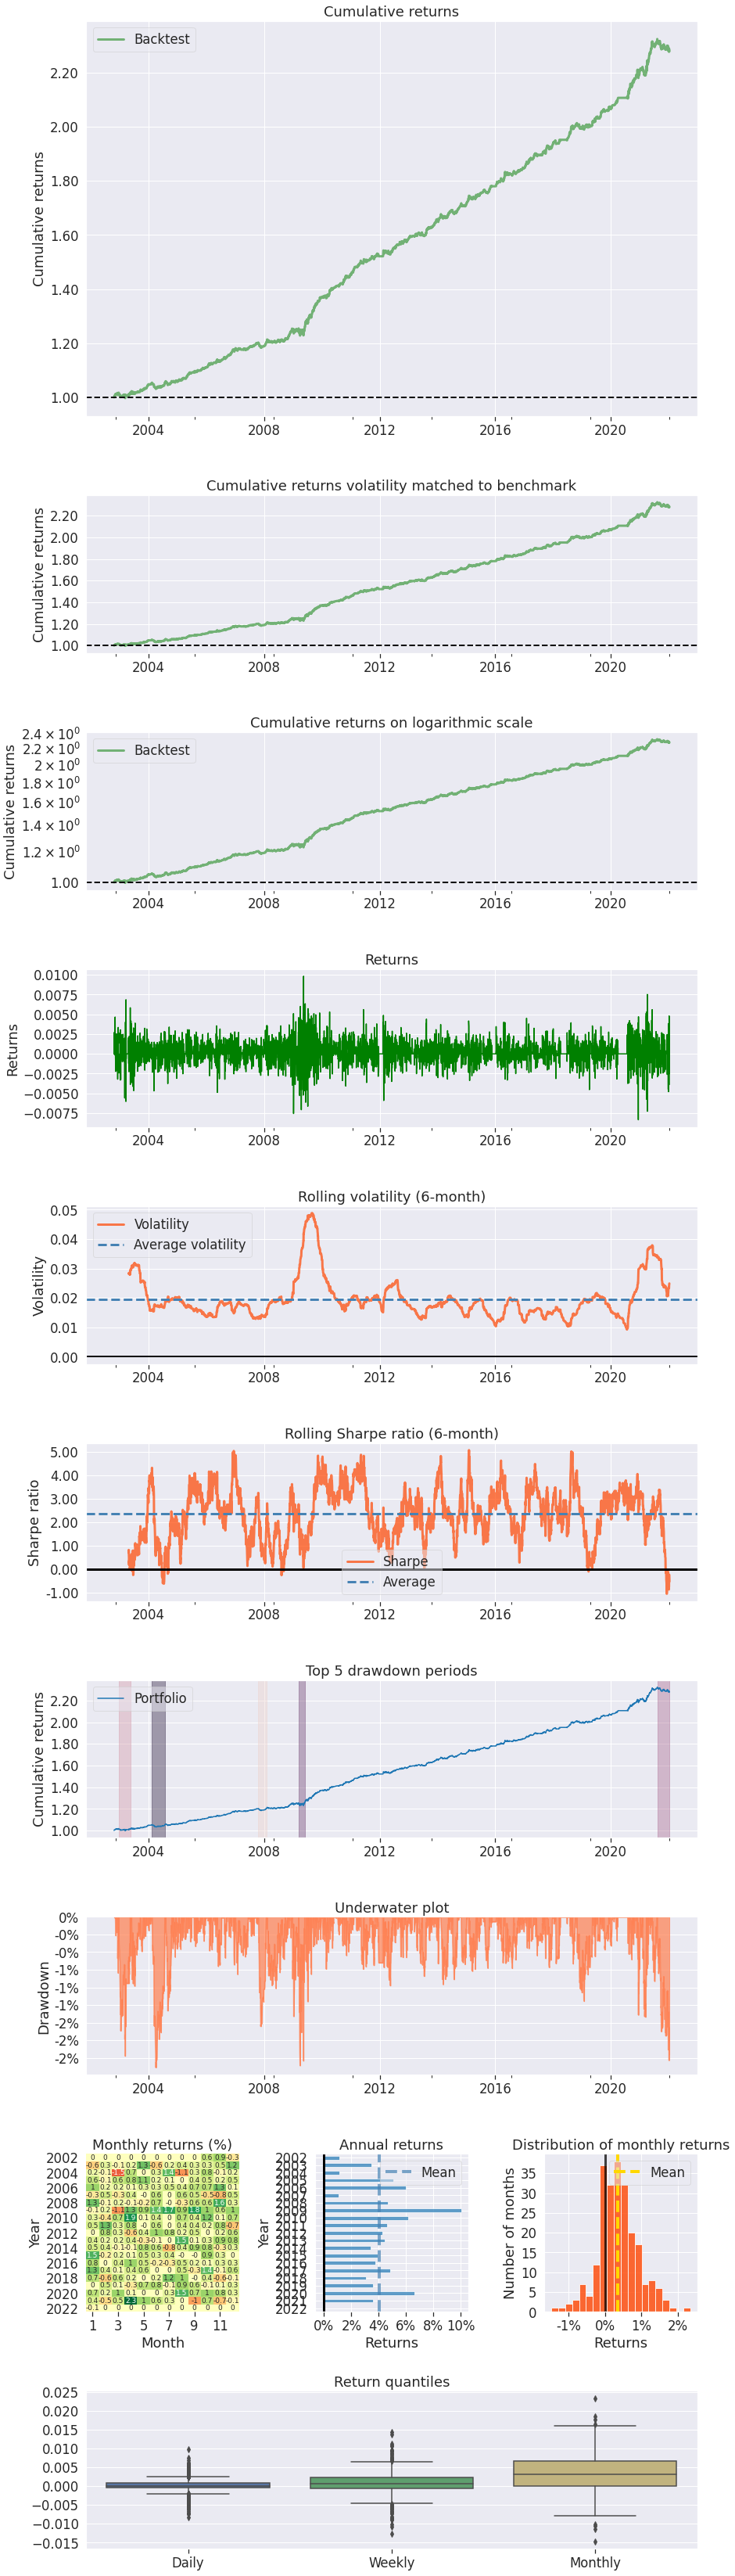

In [755]:
#Get Data and set parameters
# indices = ['^GSPC','^DJI'] #main pair
indices = ['^DJI','^RUA']
#Don't change this, we will keep the rest of the data as test data
termDates = ['01-01-2001','01-10-2022']
# termDates = ['01-01-2002','01-10-2022']
price_data = get_data(type ='index',col_list = indices, termDates = termDates)
alter_data = get_data(type = 'alter', termDates=termDates)
intersect = price_data.index.intersection(alter_data.index)
price_data = price_data.loc[intersect.values]
# price_data = price_data.loc[alter_data.index.values]
alter_data["Flat"] = alter_data['Yield_30Y'] - alter_data['fedfunds']
alter_data["vol_spread"] = alter_data[indices[0]] - alter_data[indices[0]]
alter_data["vix"] = alter_data[indices[0]]
alter_cols = ['fedfunds','vix','vol_spread','Flat','News Sentiment']
alter_data = alter_data[alter_cols]
alter_data = alter_data.loc[intersect.values]
# can change this as per your requirement
spy = price_data[indices[0]]
qqq = price_data[indices[1]]
spy_price = np.array(spy)
qqq_price = np.array(qqq)

#Train, Test split
x = np.array(spy_price)
y = np.array(qqq_price)

#trading params
formation = 252
trading_period = 63

alter_data = alter_data.values
all_returns = []
all_spread = []
all_startegy = []
sp2 = []
i = 0

while(i < len(x)- formation - trading_period):
    x_train, x_test = x[i:i+formation], x[i+formation:i+formation+trading_period]
    y_train, y_test = y[i:i+formation], y[i+formation:i+formation+trading_period]  
    temp_spread,strategy = get_strategy_copula2(x_train, y_train, x_test, y_test, isconver=False)
    temp_returns = calculate_return(strategy, x_test, y_test)
    all_startegy.extend(strategy)
    all_spread.extend(temp_spread)
    all_returns.extend(temp_returns)
    i += trading_period

dates = np.asarray(price_data.index.values[formation:], dtype='datetime64[s]')
dates = pd.to_datetime(price_data.index.values[formation:])
rets = pd.Series(data = all_returns, index = dates[-len(all_spread):])
rets = rets.tz_localize('UTC')
fig = pf.create_returns_tear_sheet(returns=rets, return_fig=True)
for ax in fig.axes:
        ax.tick_params(
        axis='x',           # changes apply to the x-axis
        which='both',       # both major and minor ticks are affected
        bottom=True,
        top=False,
        labelbottom=True)    # labels along the bottom edge are on
  # labels along the bottom edge are on

# fig.savefig("results/dji_snp_Plain_Copula.png")
# winners = []
# i = 0
# cumret = np.array(all_returns)
# cumret = cumret + 1.0
# cumret = cumret.cumprod()
# while i < len(all_returns):
#     if all_startegy[i] == 0:
#        winners.append("NONE")
#     elif all_startegy[i] == -1:
#         init = i
#         while(i < len(all_returns)-1):
#               if all_startegy[i] == 0:
#                  break   
#               i += 1

#         if cumret[i] - cumret[init] > 0:
#            winners.append("WIN")
#         else:
#             winners.append("LOSE")
#         j = init+1
#         while(j <= i):
#             winners.append("NONE")
#             j += 1          
#     else :
#         init = i
#         while(i < len(all_returns)-1):
#               if all_startegy[i] == 0:
#                  break
#               i += 1
#         if cumret[i] - cumret[init] > 0:
#            winners.append("WIN")
#         else:
#             winners.append("LOSE")
#         j = init+1
#         while(j <= i):
#             winners.append("NONE")
#             j += 1 
#     i += 1
    
# rets = pd.DataFrame(data = {"returns" : all_returns, "divergent" : all_startegy, "cummret" : cumret, "results" : winners}, index = dates[-len(all_spread):])
# rets.to_csv("results/dji_snp_plain_copula.csv")

<ipython-input-750-e876424a5d50>:44: RuntimeWarning: divide by zero encountered in log
  return np.log(pdf)
<ipython-input-750-e876424a5d50>:142: RuntimeWarning: overflow encountered in double_scalars
  loglikelihood = sum(lpdf)
<ipython-input-750-e876424a5d50>:42: RuntimeWarning: divide by zero encountered in double_scalars
  pdf = c * (u * v) ** (-1) * (A ** (-2 + 2 / theta)) * ((np.log(u) * np.log(v)) ** (theta - 1)) * (1 + (theta - 1) * A ** (-1 / theta))
<ipython-input-750-e876424a5d50>:42: RuntimeWarning: invalid value encountered in double_scalars
  pdf = c * (u * v) ** (-1) * (A ** (-2 + 2 / theta)) * ((np.log(u) * np.log(v)) ** (theta - 1)) * (1 + (theta - 1) * A ** (-1 / theta))
<ipython-input-750-e876424a5d50>:21: RuntimeWarning: divide by zero encountered in double_scalars
  MI_u_v = C_uv * (A ** ((1 - theta) / theta)) * (-np.log(v)) ** (theta - 1) * (1.0 / v)
<ipython-input-750-e876424a5d50>:21: RuntimeWarning: invalid value encountered in double_scalars
  MI_u_v = C_uv * 

I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent
I am convergent


<ipython-input-750-e876424a5d50>:6: RuntimeWarning: divide by zero encountered in double_scalars
  MI_u_v = v ** (-theta - 1) * (u ** (-theta) + v ** (-theta) - 1) ** (
<ipython-input-750-e876424a5d50>:6: RuntimeWarning: invalid value encountered in double_scalars
  MI_u_v = v ** (-theta - 1) * (u ** (-theta) + v ** (-theta) - 1) ** (
<ipython-input-750-e876424a5d50>:8: RuntimeWarning: divide by zero encountered in double_scalars
  MI_v_u = u ** (-theta - 1) * (u ** (-theta) + v ** (-theta) - 1) ** (
<ipython-input-750-e876424a5d50>:8: RuntimeWarning: invalid value encountered in double_scalars
  MI_v_u = u ** (-theta - 1) * (u ** (-theta) + v ** (-theta) - 1) ** (
c:\Users\Lakshay Garg\Anaconda3\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
c:\Users\Lakshay Garg\Anaconda3\lib\site-packages\pyfolio\plotting

Start date,2002-10-21
End date,2022-01-10
Total months,226
,Backtest
Annual return,4.77%
Cumulative returns,141.053%
Annual volatility,2.058%
Sharpe ratio,2.28
Calmar ratio,2.41
Stability,0.98
Max drawdown,-1.976%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.98,2002-12-19,2003-03-11,2003-05-14,105
1,1.64,2021-08-10,2021-11-17,NaT,NaN
2,1.55,2007-10-19,2007-11-19,2008-01-28,72
3,1.42,2021-02-05,2021-03-16,2021-03-26,36
4,1.41,2008-12-18,2009-01-09,2009-03-20,67


c:\Users\Lakshay Garg\Anaconda3\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
c:\Users\Lakshay Garg\Anaconda3\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
c:\Users\Lakshay Garg\Anaconda3\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


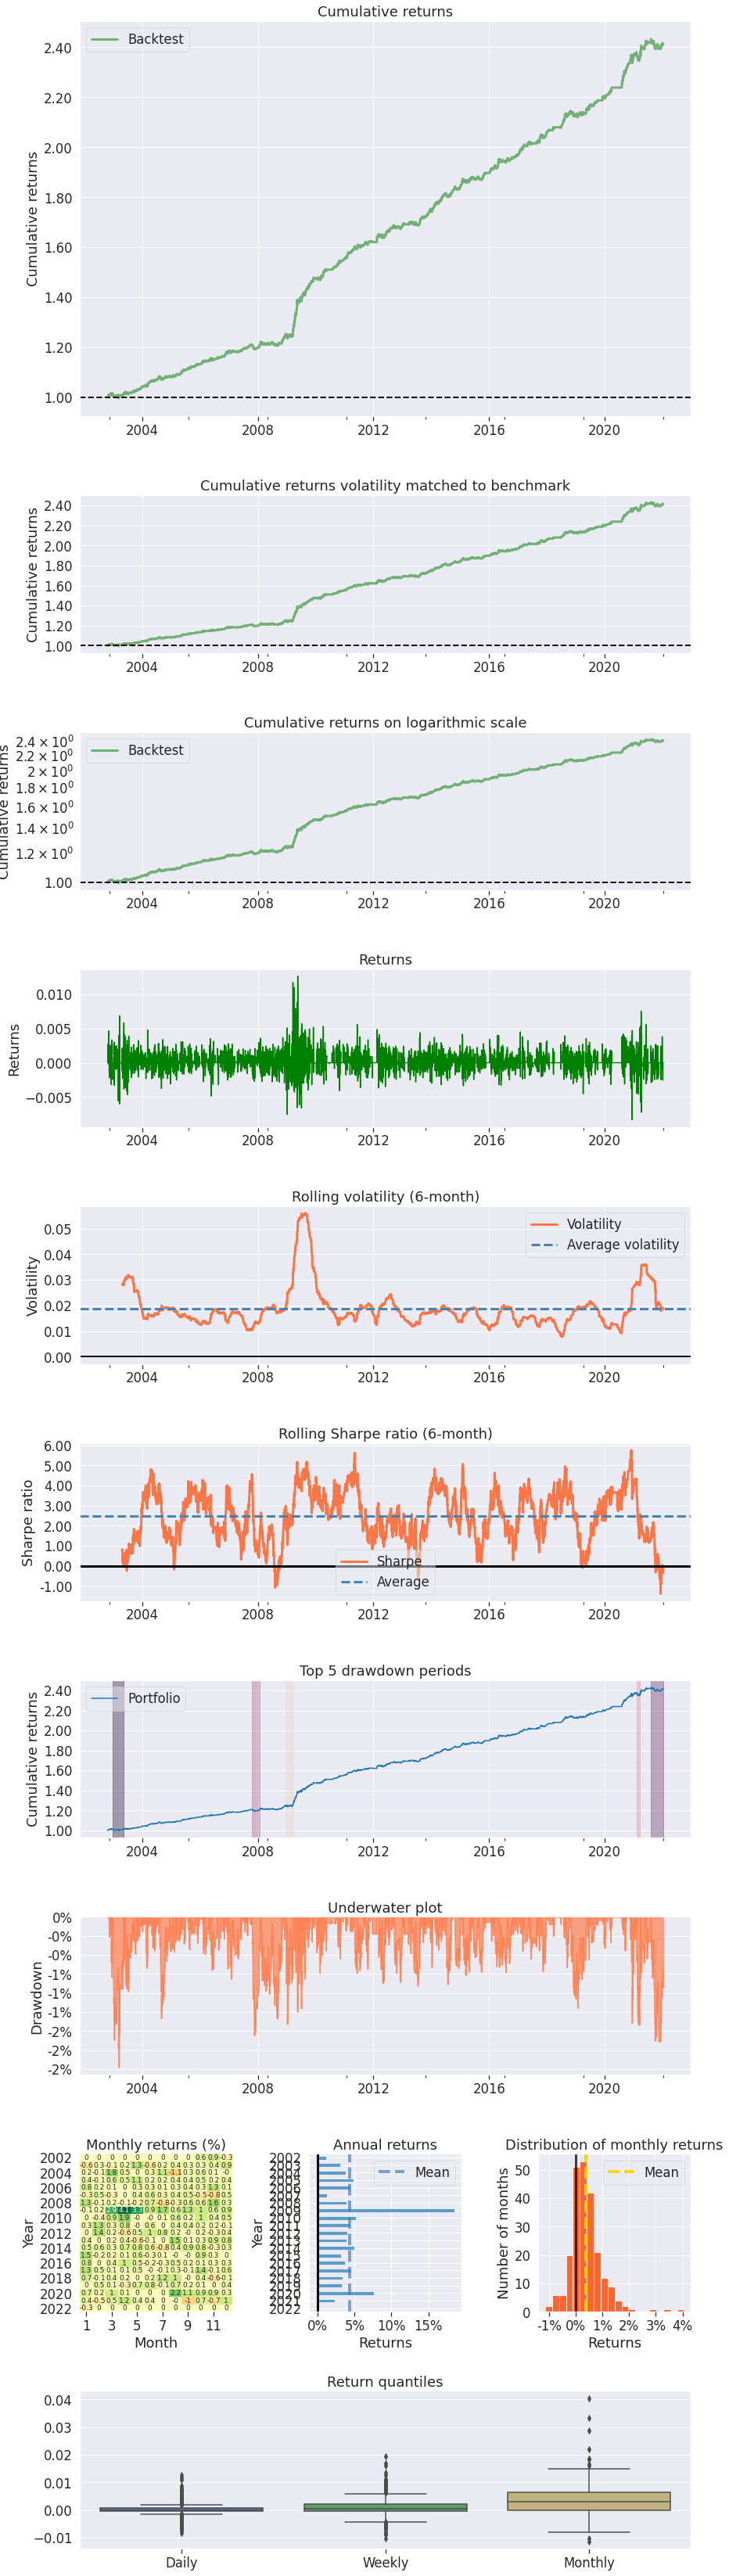

In [756]:
import numpy as np

all_returns = []
all_spread = []
all_startegy = []
i = 0
while(i < len(x)- formation - trading_period):
    x_train, x_test = x[i:i+formation], x[i+formation:i+formation+trading_period]
    y_train, y_test = y[i:i+formation], y[i+formation:i+formation+trading_period]
    alter_train, alter_test = alter_data[i:i+formation,:], alter_data[i+formation:i+formation+trading_period,:]
    temp_spread, strategy = get_strategy_copula_rm2(x_train, y_train, x_test, y_test, \
                                                   alter_train, alter_test)
    temp_returns = calculate_return(strategy, x_test, y_test)
    all_spread.extend(temp_spread)
    all_returns.extend(temp_returns)
    i += trading_period

dates = np.asarray(price_data.index.values[formation:], dtype='datetime64[s]')
dates = pd.to_datetime(price_data.index.values[formation:])
rets = pd.Series(data = all_returns, index = dates[-len(all_spread):])
rets = rets.tz_localize('UTC')
fig = pf.create_returns_tear_sheet(returns=rets, return_fig=True)
for ax in fig.axes:
        ax.tick_params(
        axis='x',           # changes apply to the x-axis
        which='both',       # both major and minor ticks are affected
        bottom=True,
        top=False,
        labelbottom=True)    # labels along the bottom edge are on

# fig.savefig("results/snp_dji_rm_Copula.png")

# winners = []
# i = 0
# cumret = np.array(all_returns)
# cumret = cumret + 1.0
# cumret = cumret.cumprod()
# # while i < len(all_returns):
# #     if all_startegy[i] == 0:
# #        winners.append("NONE")
# #     elif all_startegy[i] == -1:
# #         init = i
# #         while(i < len(all_returns)-1):
# #               if all_startegy[i] == 0:
# #                  break   
# #               i += 1

# #         if cumret[i] - cumret[init] > 0:
# #            winners.append("WIN")
# #         else:
# #             winners.append("LOSE")
# #         j = init+1
# #         while(j <= i):
# #             winners.append("NONE")
# #             j += 1          
# #     else :
# #         init = i
# #         while(i < len(all_returns)-1):
# #               if all_startegy[i] == 0:
# #                  break
# #               i += 1
# #         if cumret[i] - cumret[init] > 0:
# #            winners.append("WIN")
# #         else:
# #             winners.append("LOSE")
# #         j = init+1
# #         while(j <= i):
# #             winners.append("NONE")
# #             j += 1 
# #     i += 1
    
# rets = pd.DataFrame(data = {"returns" : all_returns, "cummret" : cumret}, index = dates[-len(all_spread):])
# rets.to_csv("results/dji_snp_rm_copula.csv")

In [749]:
rets = pd.DataFrame(data = {"returns" : all_returns, "cumret" : cumret}, index = dates[-len(all_spread):])
rets.to_csv("results/dji_rua_rm_copula.csv")

In [738]:
winners = []
i = 0
cumret = np.array(all_returns)
cumret = cumret + 1.0
cumret = cumret.cumprod()
while i < len(all_returns):
    if all_startegy[i] == 0:
       winners.append("NONE")
    elif all_startegy[i] == -1:
        init = i
        while(i < len(all_returns)-1):
              if all_startegy[i] == 0:
                 break   
              i += 1

        if cumret[i] - cumret[init] > 0:
           winners.append("WIN")
        else:
            winners.append("LOSE")
        j = init+1
        while(j <= i):
            winners.append("NONE")
            j += 1          
    else :
        init = i
        while(i < len(all_returns)-1):
              if all_startegy[i] == 0:
                 break
              i += 1
        if cumret[i] - cumret[init] > 0:
           winners.append("WIN")
        else:
            winners.append("LOSE")
        j = init+1
        while(j <= i):
            winners.append("NONE")
            j += 1 
    i += 1
rets = pd.DataFrame(data = {"returns" : all_returns, "cummret" : cumret, "results" : winners}, index = dates[-len(all_spread):])
rets.to_csv("results/rua_dji_rm_copula.csv")

IndexError: list index out of range

In [745]:
rets = pd.DataFrame(data = {"returns" : all_returns, "cummret" : cumret, "results" : winners}, index = dates[-len(all_spread):])
rets.to_csv("results/rua_dji_rm_copula.csv")

0


In [396]:
from math import nan
from sklearn.model_selection import GridSearchCV
# build your machine learning model here
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Scaling data
from sklearn.preprocessing import StandardScaler
data = pd.read_csv("DataFiles/train.csv")
y = data["Classification"]
x = data.drop(columns=["Classification","Date"])
# x = x[['Flat']]
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

class RolledTimeSeriesSplit(TimeSeriesSplit):
    def __init__(self, n_splits, train_test_ratio=None):
        super().__init__(n_splits)
        self.train_test_ratio = train_test_ratio

    def fit(self,X, y=None):
        return self
    
    def set_params(self, n_splits, train_test_ratio):
        self.train_test_ratio = train_test_ratio
        super().__init__(n_splits)
        
    def transform(self, X):
        return X
    
    def split(self, X, y=None, groups=None):
        if self.train_test_ratio is None:
            return super().split(X, y, groups)
        else:
            test_size = X.shape[0]//(n_splits + 1)
            self.max_train_size = int(np.floor(self.train_test_ratio * len(test_index)))
            return super().split(X, y, groups)

In [680]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score

# pipeline = Pipeline([
#     ('time_split', RolledTimeSeriesSplit(n_splits=44,train_test_ratio=3)),
#     ('scaler', StandardScaler()),
#     ('classifier', XGBClassifier(missing = nan,gamma=1,learning_rate=0.5,max_depth=4,reg_lambda=.01,scale_pos_weight=3.5,objective='binary:logistic'))
# ])

pipeline2 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca' , PCA(n_components=2)),
    ('classifier', KNeighborsClassifier(n_neighbors=2, p = 2))
])

pipeline3 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca' , PCA(n_components=3)),
    ('classifier', LogisticRegression(fit_intercept=True, penalty="elasticnet", solver='saga', l1_ratio=0.8))
])

lb = LabelBinarizer()
y_prep = lb.fit_transform(y.values)
print(y.values[0])
print(y_prep[0])
x_prep = pipeline2.named_steps['scaler'].fit_transform(x.values.reshape(-1,5))
x_prep = pipeline2.named_steps['pca'].fit_transform(x_prep)
clf = pipeline2.fit(x_prep,y_prep)
print(clf.score(x_prep,y_prep))
print(roc_auc_score(y_prep.flatten(), clf.predict(x_prep)))
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE(n_components = 2, random_state=0)
tsne_res = tsne.fit_transform(x_prep)
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = y_prep.flatten(), palette = sns.hls_palette(2), legend = 'full')

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [242]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(gamma=1,learning_rate=0.5,max_depth=4,scale_pos_weight=3.5,objective='binary:logistic'))
])
from sklearn.preprocessing import OneHotEncoder

categorical_pipeline = Pipeline(
    steps=[
        ("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

param_grid = {
    'classifier__max_depth' : [8,10,15,20],
}
y_prep = categorical_pipeline.fit_transform(y.values.reshape(-1,1))
# perform grid search
grid_search = GridSearchCV(pipeline, param_grid, n_jobs=4,scoring="accuracy")
grid_search.fit(x,y_prep)
grid_search.best_params_

0.30192810457516345